In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa

import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [2]:
DATA_DIR = 'data'

# Directory to save logs and trained model
ROOT_DIR = ''

In [3]:
#os.chdir('Mask_RCNN')


In [4]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [5]:
import keras
import tensorflow as tf

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9017184020701477055
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10720899668177033249
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12219606409116895408
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23333067162
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18192443174474061078
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [7]:
import keras

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [8]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [ ]:
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
#!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"


In [9]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [10]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    BATCH_SIZE= 6
    NUM_CLASSES = 2  # background + 1 pneumonia classes

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 5
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.4
    DETECTION_NMS_THRESHOLD = 0.1
    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.4
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [11]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [12]:
ls

anim/                                              pneumonia20200619T1251/
app.py                                             pneumonia20200619T1333/
build/                                             pneumonia20200619T1423/
data/                                              pneumonia20200619T1432/
dist/                                              pneumonia20200619T1502/
fastai_boundingbox.ipynb                           preprocess.py
fastai-rsna.ipynb                                  __pycache__/
fastai_train.py                                    RCNN_inference.ipynb
ff30520c-68c9-4d17-acb0-f44eb1f4eb1c_detected.png  README.md
ff659b3e-123c-4501-ab4b-be41216160ac_detected.png  requirements.txt
gradcam.py                                         setup.cfg
LICENSE                                            setup.py
MANIFEST.in                                        snap/
mask_rcnn_coco.h5                                  stage_2_train_labels.csv
mask_rcnn.egg-info/                      

In [13]:
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [14]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)


In [15]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [16]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.2902.1517874299.15199
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2902.1517874299.15199
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time          

In [17]:
ORIG_SIZE = 1024


In [18]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

25184 1500


In [19]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [20]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    ad310f52-5ed7-46a5-a083-3ffd1bc4bb71
 x                                             160
 y                                             262
 width                                         227
 height                                        474
 Target                                          1
 Name: 18328, dtype: object,
 patientId    ad310f52-5ed7-46a5-a083-3ffd1bc4bb71
 x                                             538
 y                                             242
 width                                         224
 height                                        505
 Target                                          1
 Name: 18329, dtype: object]

In [21]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

48
6820
24948


(-0.5, 1023.5, 1023.5, -0.5)

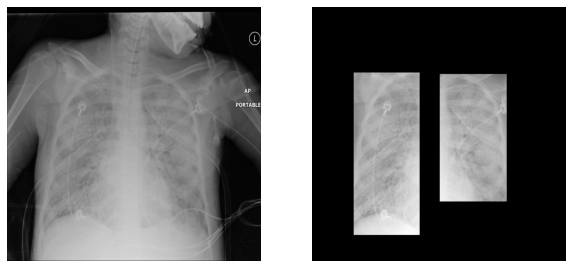

In [22]:
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    print(image_id)
    image_fp = dataset_train.image_reference(image_id)
    #print(image_fp)
    image = dataset_train.load_image(image_id)
    #print(image)
    mask, class_ids = dataset_train.load_mask(image_id)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')



/home/sahand/anaconda3/envs/rcnn/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


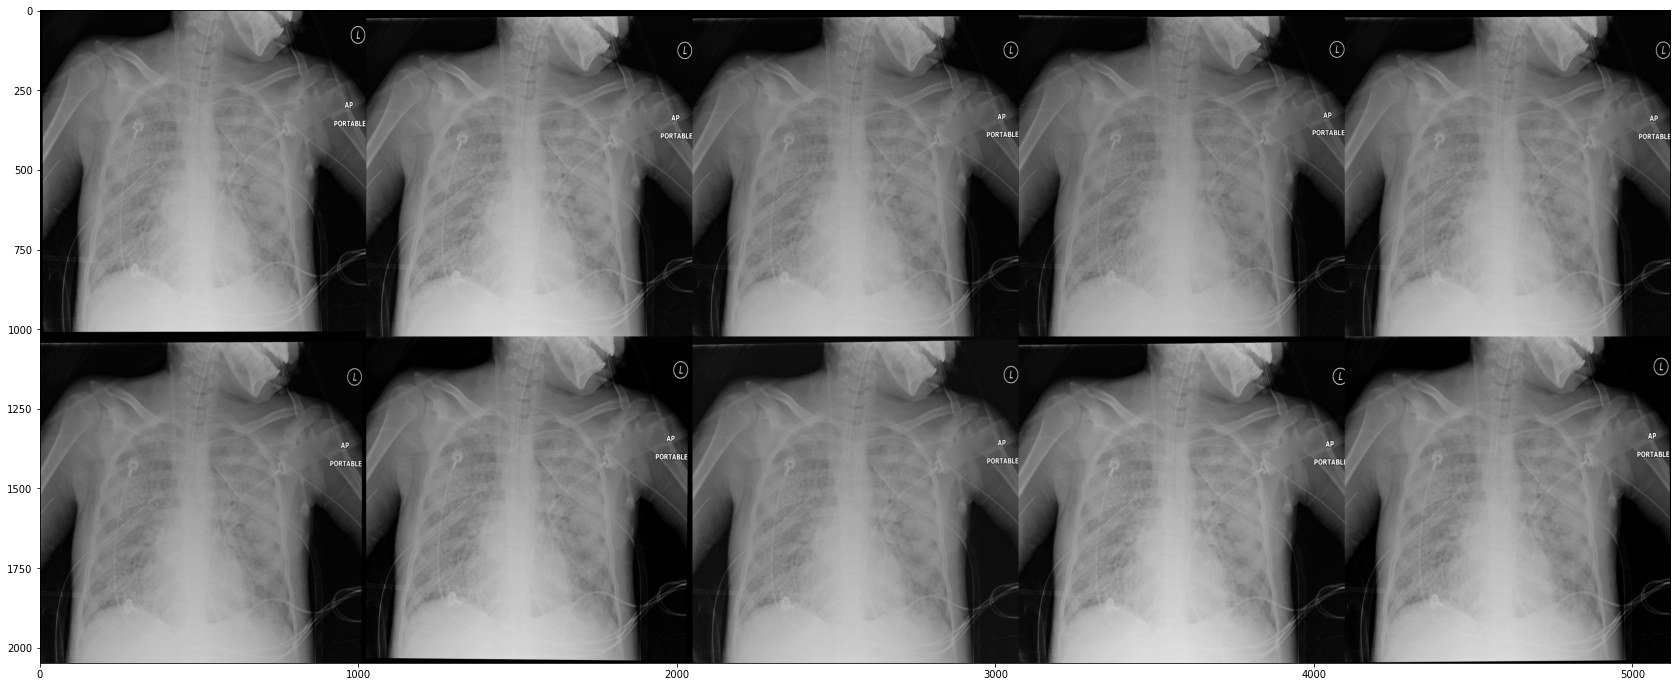

In [23]:
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [25]:

model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
LEARNING_RATE = 0.006

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=16,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/10,
            epochs=32,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

In [ ]:
plt.figure(figsize=(17,5))
plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

In [ ]:
ROOT_DIR

In [38]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
model_path = "weights/mask_rcnn_pneumonia_0027.h5"
#model_path = "weights/mask_rcnn_pneumonia_0010.h5"

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  weights/mask_rcnn_pneumonia_0027.h5


In [39]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

1062
(512, 512, 3)

*** No instances to display *** 


*** No instances to display *** 

771
(512, 512, 3)
597
(512, 512, 3)

*** No instances to display *** 

1462
(512, 512, 3)

*** No instances to display *** 

825
(512, 512, 3)

*** No instances to display *** 



IndexError: list index out of range

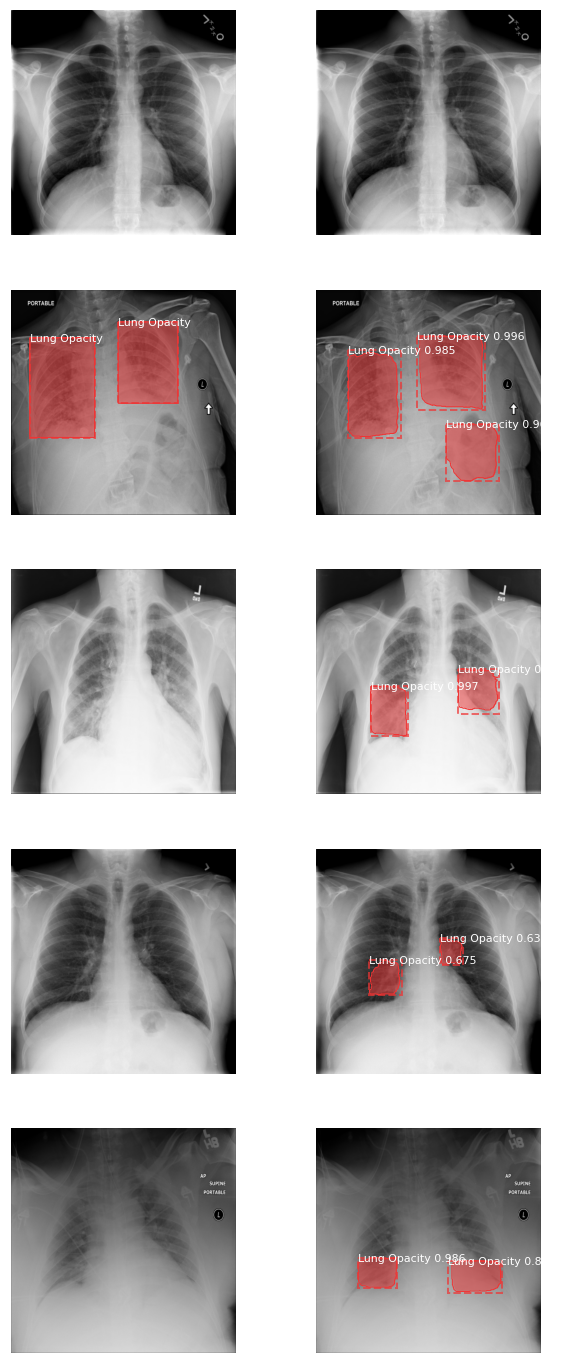

In [40]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))
l = [1062,771,597,1462,825]

for i in range(6):
    #image_id = random.choice(dataset.image_ids)
    image_id = l[i]
    print(image_id)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    


In [ ]:
test_image_fps = get_dicom_fps(test_dicom_dir)


2e4a1318-c21b-462e-a387-6d77222b99af
[272 308 338 384]
x 616 y 544 h 152 w 132
1a0203a7-b56f-40bf-9cce-cba5163eb737
[130 294 232 411]
x 588 y 260 h 234 w 204
[121 127 255 235]
x 254 y 242 h 216 w 268
28c25252-860a-4f65-ae97-c136b577da2f
[232  92 350 196]
x 184 y 464 h 208 w 236
[288 325 371 397]
x 650 y 576 h 144 w 166
[ 57 132 139 227]
x 264 y 114 h 190 w 164
2f4562a7-ec65-4a86-8cc4-2fd276a62332
[272 124 352 189]
x 248 y 544 h 130 w 160


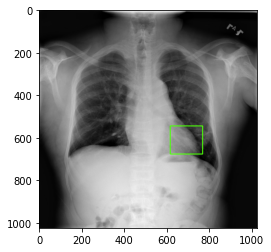

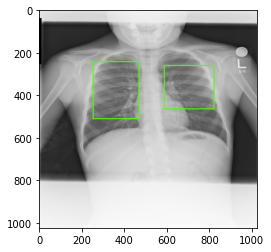

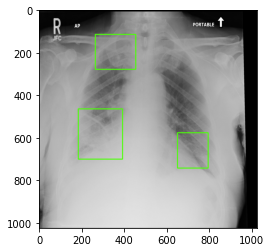

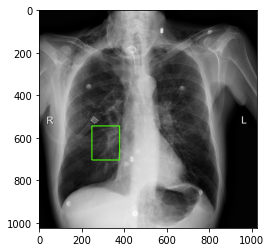

In [34]:
ORIG_SIZE = 1024

def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()